In [55]:
# Подключение библиотек

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from pylab import rcParams
import itertools
import time
from sklearn.preprocessing import MaxAbsScaler

## UPD. Предсказал несовсем то что нужно было. Это второй ноутбут, он почти не отлчичается от первого, просто готовые обработтаные данный загружены из фаила и заного обучена модель и получены предсказания. Раличия ноутбуков только в самом конце

Описание:

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

train.csv:
user_id - уникальный id пользователя
order_completed_at - дата заказа
cart - список уникальных категорий (category_id), из которых состоял заказ
В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

sample_submission.csv:
Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

In [56]:
df = pd.read_csv("C://Users//Ergney//Downloads//data//train.csv", encoding="utf-8")

In [57]:
df.head(10)

user_id   order_completed_at  cart
0        2  2015-03-22 09:25:46   399
1        2  2015-03-22 09:25:46    14
2        2  2015-03-22 09:25:46   198
3        2  2015-03-22 09:25:46    88
4        2  2015-03-22 09:25:46   157
5        2  2015-03-22 09:25:46    82
6        2  2015-03-22 09:25:46   134
7        2  2015-03-22 09:25:46    16
8        2  2015-03-22 09:25:46   409
9        2  2015-03-22 09:25:46   384

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


In [59]:
#Думаю здесь будет уместо рассмотреть данные на примере нескольких конкретных юзеров. 
#Пусть это будут 1, 2 и самый тот кто приобрел больше всего товаров.

top_user_id = df['user_id'].mode()[0]

df.loc[df['user_id'] == 1].head(10)

user_id   order_completed_at  cart
65467         1  2019-05-08 16:09:41    55
709747        1  2020-01-17 14:44:23    82
709748        1  2020-01-17 14:44:23   798
709749        1  2020-01-17 14:44:23    86
709750        1  2020-01-17 14:44:23   421
709751        1  2020-01-17 14:44:23   204
709752        1  2020-01-17 14:44:23    55
800645        1  2020-02-06 22:46:55    55
921504        1  2020-03-02 13:43:20    23
921505        1  2020-03-02 13:43:20    14

In [60]:
df.loc[df['user_id'] == 2].head(10)

user_id   order_completed_at  cart
0        2  2015-03-22 09:25:46   399
1        2  2015-03-22 09:25:46    14
2        2  2015-03-22 09:25:46   198
3        2  2015-03-22 09:25:46    88
4        2  2015-03-22 09:25:46   157
5        2  2015-03-22 09:25:46    82
6        2  2015-03-22 09:25:46   134
7        2  2015-03-22 09:25:46    16
8        2  2015-03-22 09:25:46   409
9        2  2015-03-22 09:25:46   384

In [61]:
df.loc[df['user_id'] == top_user_id].head(10)

user_id   order_completed_at  cart
26323      380  2018-09-26 19:14:06    61
26324      380  2018-09-26 19:14:06   402
26325      380  2018-09-26 19:14:06   400
26326      380  2018-09-26 19:14:06    57
26327      380  2018-09-26 19:14:06    43
26328      380  2018-09-26 19:14:06   376
26329      380  2018-09-26 19:14:06   379
26330      380  2018-09-26 19:14:06   383
26331      380  2018-09-26 19:14:06   398
26332      380  2018-09-26 19:14:06   101

In [62]:
# Попробую визуализировать некоторые статитстики в виде графиков. 

In [63]:
# Построение графика, отражающего колличество купленных товаров каждой категории для одного пользователя.

def get_graph_products_count_for_user(df, user_id):
    
    user = df['cart'].loc[df['user_id'] == user_id].value_counts()
    
    size = user.shape[0]
    
    rcParams["figure.figsize"] = size/3.5, size/2.7
    
    title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "#808080",
    "family": "serif",
    }
    
    label_font = {
    "fontsize": 12,
    "family": "serif",
    }
    
    user.plot(kind="barh", label='ID товара', ec="black")
    plt.xlabel("Колличество покупок товара", fontdict=label_font)
    plt.title(f"График колличества приобритений различных товаров пользователя {user_id}", fontdict=title_font)
    plt.ylabel("ID товара", fontdict=label_font)
    plt.show()

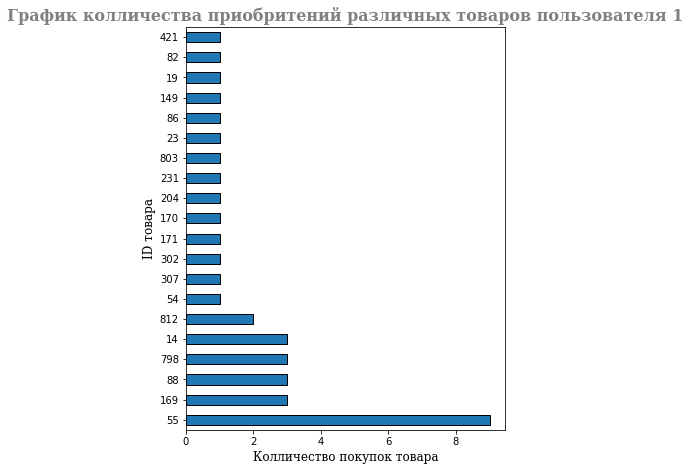

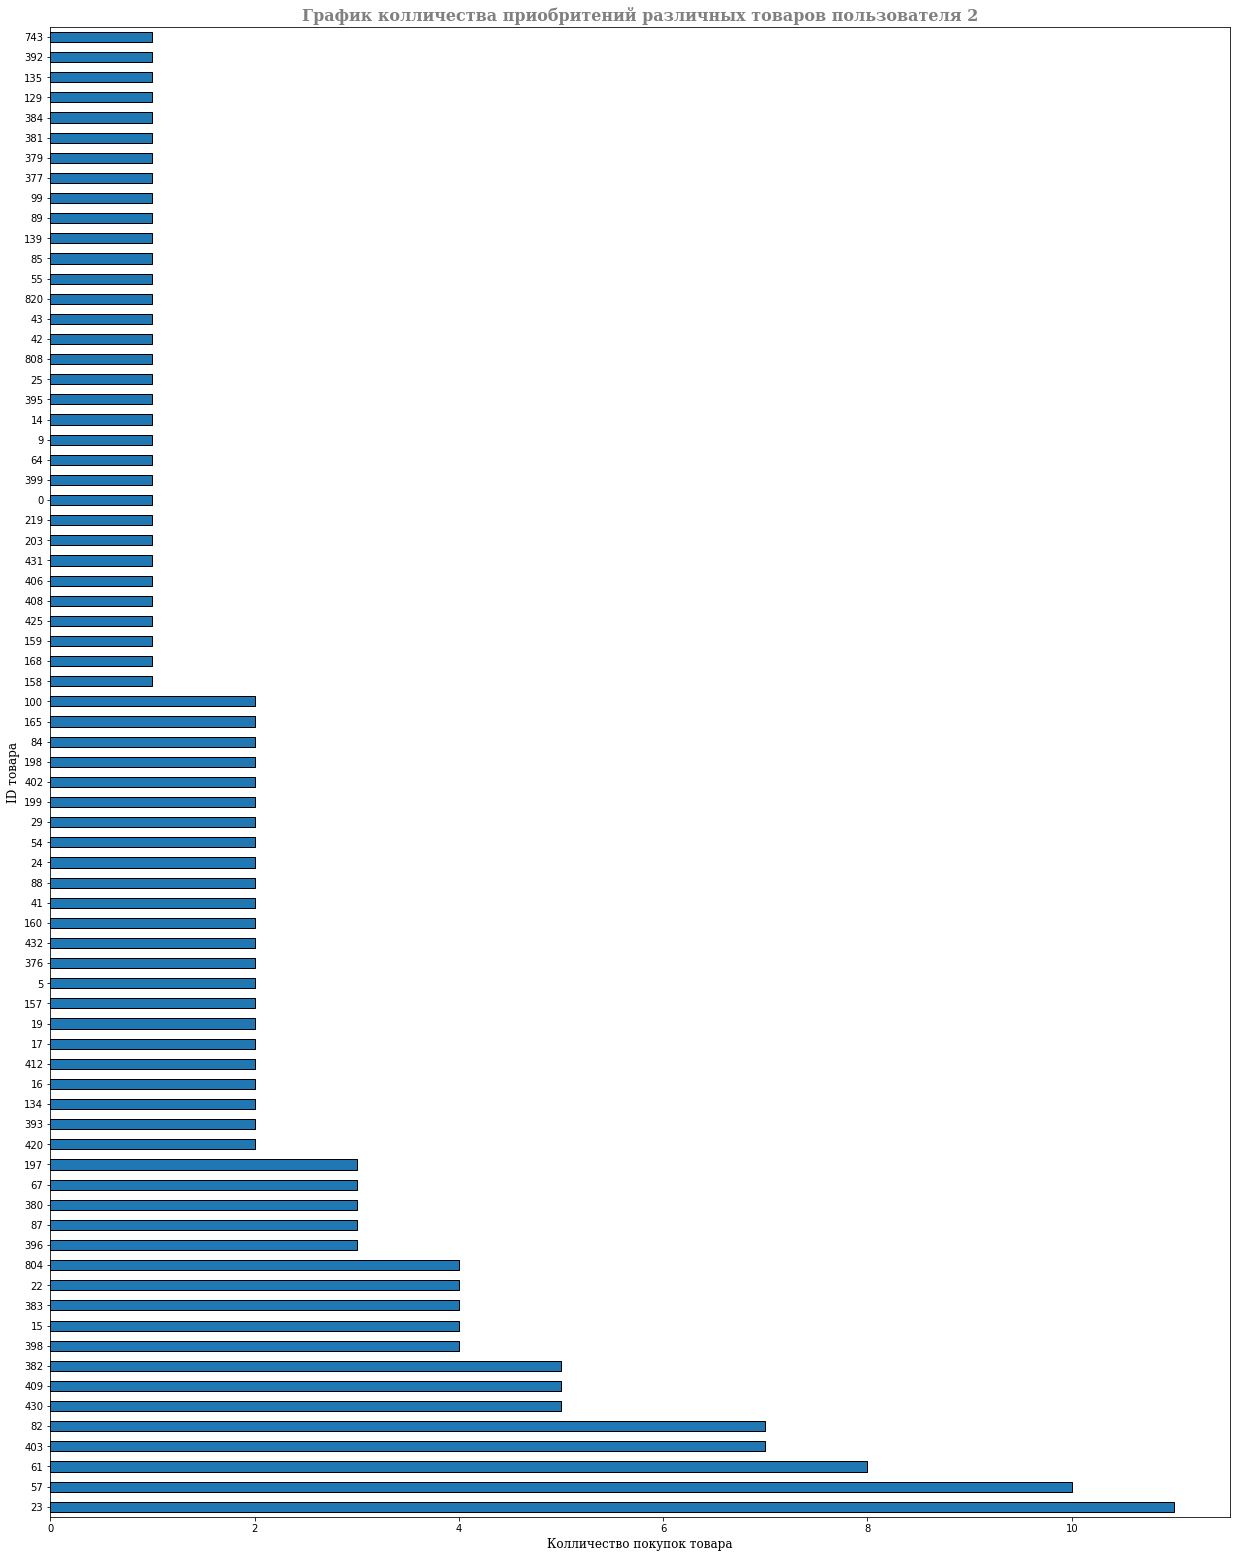

In [64]:
get_graph_products_count_for_user(df, 1)
get_graph_products_count_for_user(df, 2)
#get_graph_products_count_for_user(df, top_user_id)

In [65]:
dates = df['order_completed_at'].values
dates.max(), dates.min()

('2020-09-03 23:45:45', '2015-03-22 09:25:46')

In [66]:
# Теперь побую графики которые будет отражать активность пользователя по кварталам.

def get_graph_activites_user_for_time(df, user_id):
    data = df['order_completed_at'].loc[df['user_id'] == user_id].values
    # idx = df['order_completed_at'].loc[df['user_id'] == user_id].index
    
    dict_quarter = {}
    years = [i for i in range(2015, 2021)]
    quarters = [1, 4, 7, 10]
    for year, quarter_idx in itertools.product(years, range(4)):
        dict_quarter[f'{year}-{quarter_idx+1}'] = 0
        if quarter_idx < 3:
            start_quarter = datetime.strptime(f'{year}.{quarters[quarter_idx]}', '%Y.%m')
            end_quarter = datetime.strptime(f'{year}.{quarters[quarter_idx+1]}', '%Y.%m')
        else:
            start_quarter = datetime.strptime(f'{year}.{quarters[quarter_idx]}', '%Y.%m')
            end_quarter = datetime.strptime(f'{year+1}.{quarters[-1]}', '%Y.%m')
        for i in data:
            date = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
            if start_quarter < date < end_quarter:
                dict_quarter[f'{year}-{quarter_idx+1}'] += 1
                
    result = pd.Series(dict_quarter)
    
    rcParams["figure.figsize"] = 12, 9
                
    title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "#808080",
    "family": "serif",
    }
    
    label_font = {
    "fontsize": 12,
    "family": "serif",
    }

    result.plot(kind="bar", label="Колличество покупок", ec="black")
    plt.title(f"График колличества приобритений различных товаров пользователя {user_id}", fontdict=title_font)
    plt.xlabel("Квартал", fontdict=label_font)
    plt.ylabel("Колличество покупок", fontdict=label_font)
    plt.show()

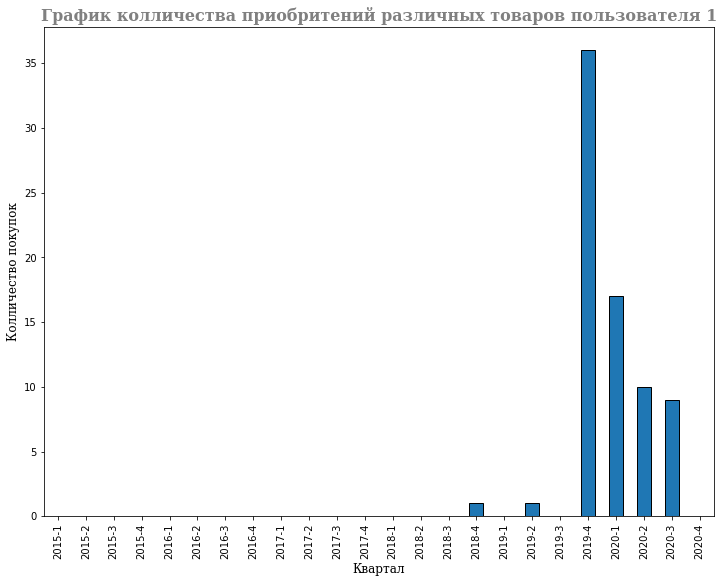

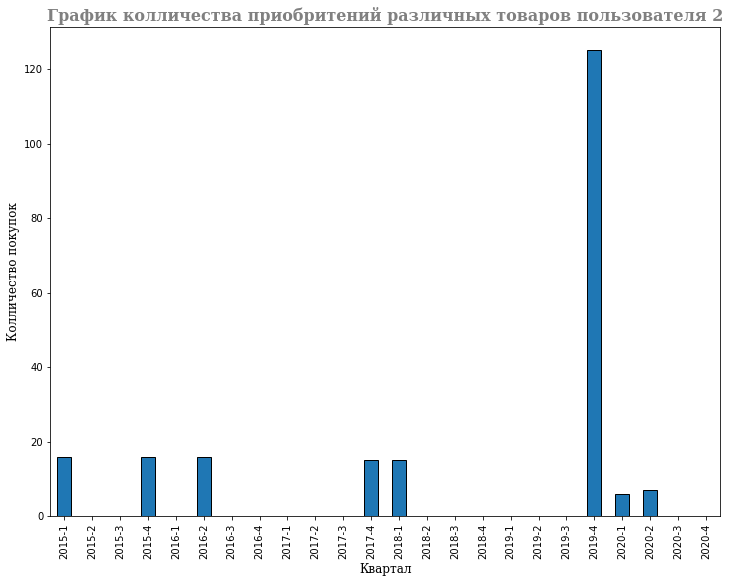

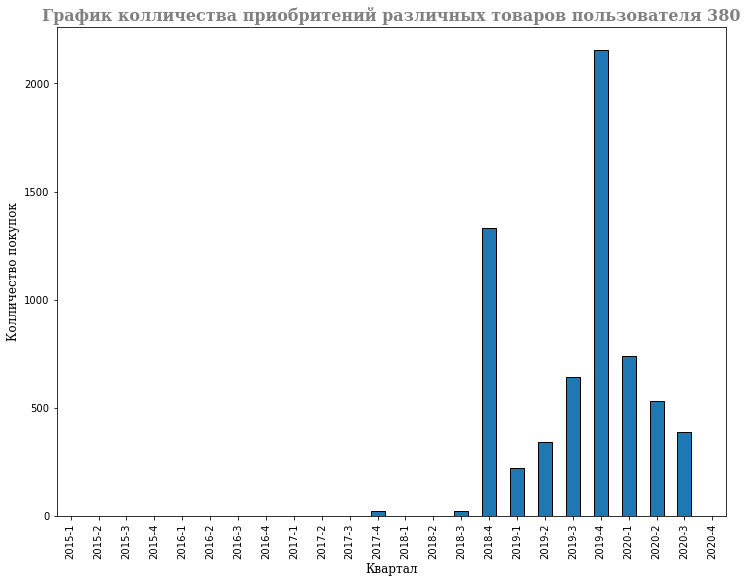

In [13]:
get_graph_activites_user_for_time(df, 1)
get_graph_activites_user_for_time(df, 2)
get_graph_activites_user_for_time(df, top_user_id)

Думаю для предсказаний следующие признаки будут значимы:

    1.Делал ли вообще покупки пользователь за последний квартал\год\два\три.
    2.Делал ли пользователь покупки из данной категории за последний квартал\полугодие\год\два\три.
    3.Колличество покупок из данной категории за квартал\год\всё время.
    4.Доля покупок от всех из данной категории за квартал\год\всё время.
    5.Колличество дней с момента последней покупки.
    6.Колличество дней с момента последней покупки в категории.
    
Так же на основе этих признаков можно придумать ещё некоторые. Например:

    1.Повышение интереса пользователя к категории на данный момент. Считаться будет как повышение абсолютного количества\доли приобретенных товаров из категории по кварталам\годам.
    2.Снижение интереса пользователя к категории на данный момент. Считаться будет аналогично, но в обратную сторону.
    3.Снижение желания пользователя вообще покупать что-либо. Считаться будет как снижение абсолютного количества приобретенных товаров по кварталам\годам.

In [67]:
class Datatransform:

    def __init__(self):
        self.last_date = '2020-09-03 23:45:45'
        self.last_date_f = datetime.strptime(self.last_date, '%Y-%m-%d %H:%M:%S')

    def _get_date_delta(self, dft):
        date = dft['order_completed_at'].max()
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        delta = (self.last_date_f - date).days
        return delta

    def _get_categorys(self, df_u):
        yield from np.unique(df_u['cart'])

    def _get_users(self, df):
        yield from np.unique(df['user_id'])

    def _get_data(self, df):
        data = []
        count = 0

        last_month_datetime = '2020-08-03 23:45:45'
        last_quarter_datetime = '2020-06-03 23:45:45'
        last_years_datetime = '2019-06-03 23:45:45'
        last_three_years_datetime = '2017-06-03 23:45:45'

        for user_id in self._get_users(df=df):

            df_u = df.loc[df['user_id'] == user_id]

            buy_in_this_m = df_u.loc[(df_u['order_completed_at'] > last_month_datetime)].shape[0]
            buy_in_this_q = df_u.loc[(df_u['order_completed_at'] > last_quarter_datetime)].shape[0]
            buy_in_this_y = df_u.loc[(df_u['order_completed_at'] > last_years_datetime)].shape[0]
            buy_in_this_3y = df_u.loc[(df_u['order_completed_at'] > last_three_years_datetime)].shape[0]
            buy_all = df_u.shape[0]
            

            last_buy = self._get_date_delta(dft=df_u)
            

            for category_id in self._get_categorys(df_u=df_u):
                df_uc = df_u.loc[df['cart'] == category_id]
                count += 1
                

                c_buy_in_this_m = df_uc.loc[(df_uc['order_completed_at'] > last_month_datetime)].shape[0]
                c_buy_in_this_q = df_uc.loc[(df_uc['order_completed_at'] > last_quarter_datetime)].shape[0]
                c_buy_in_this_y = df_uc.loc[(df_uc['order_completed_at'] > last_years_datetime)].shape[0]
                c_buy_in_this_3y = df_uc.loc[df_uc['order_completed_at'] > last_three_years_datetime].shape[0]

                c_by_all = df_uc.shape[0]

                c_last_buy = self._get_date_delta(dft=df_uc)

                idx = f'{user_id};{category_id}'

                data.append([idx, buy_in_this_m, buy_in_this_q, buy_in_this_y, buy_in_this_3y,
                             buy_all, last_buy, c_buy_in_this_m, c_buy_in_this_q, c_buy_in_this_y,
                             c_buy_in_this_3y, c_by_all, c_last_buy])
                

   
        columns = ['id','buy_in_this_m', 'buy_in_this_q', 'buy_in_this_y', 'buy_in_this_3y',
                               'buy_all', 'last_buy', 'c_buy_in_this_m', 'c_buy_in_this_q', 'c_buy_in_this_y',
                               'c_buy_in_this_3y', 'c_by_all', 'c_last_buy']
    
        result = pd.DataFrame(data=data, columns=columns)
    
        return result

    def transform(self, df):
        start_time = time.time()
        
        data = self._get_data(df)
        #data[columns] = data[columns].astype("int64", errors='ignore')
        data['share_category'] = data['c_by_all'] / data['buy_all']
        
        data.loc[data['buy_in_this_y'] != 0, 'share_category_in_this_y'] = data['c_buy_in_this_y'] / data['buy_in_this_y']
        data.loc[data['buy_in_this_q'] != 0, 'share_category_in_this_q'] = data['c_buy_in_this_q'] / data['buy_in_this_q']
        data.loc[data['buy_in_this_m'] != 0, 'share_category_in_this_m'] = data['c_buy_in_this_m'] / data['buy_in_this_m']
        
        data['share_category_in_this_y'] = data['share_category_in_this_y'].fillna(0)
        data['share_category_in_this_q'] = data['share_category_in_this_q'].fillna(0)
        data['share_category_in_this_m'] = data['share_category_in_this_m'].fillna(0)
        
        data.loc[data['c_by_all'] != 0, 'interest_category_in_m'] = data['c_buy_in_this_m'] / data['c_by_all']
        data.loc[data['c_by_all'] != 0, 'interest_category_in_q'] = data['c_buy_in_this_q'] / data['c_by_all']
        data.loc[data['c_by_all'] != 0, 'interest_category_in_y'] = data['c_buy_in_this_y'] / data['c_by_all']
        
        data['interest_category_in_m'] = data['interest_category_in_m'].fillna(0)
        data['interest_category_in_q'] = data['interest_category_in_q'].fillna(0)
        data['interest_category_in_y'] = data['interest_category_in_y'].fillna(0)
        
        data['interest_buy_y'] = data['buy_in_this_y'] / data['buy_all']
        data['interest_buy_q'] = data['buy_in_this_q'] / data['buy_all']
        data['interest_buy_m'] = data['buy_in_this_m'] / data['buy_all']
        
        print("--- %s seconds ---" % (time.time() - start_time))
        
        return data

In [68]:
transform = Datatransform()
#new_data = transform.transform(df[0:1000])
#new_data = transform.transform(df[0:10000])
#new_data = transform.transform(df[0:40000])
#new_data = transform.transform(df[0:100000])
#new_data = transform.transform(df[0:200000])
#new_data = transform.transform(df[0:500000])

In [ ]:
new_data = transform.transform(df)

In [ ]:
new_data.to_csv("newdata.csv")

In [131]:
new_data.describe()

buy_in_this_m  buy_in_this_q  buy_in_this_y  buy_in_this_3y  \
count   1.117600e+06   1.117600e+06   1.117600e+06    1.117600e+06   
mean    3.165059e+01   9.548469e+01   2.422120e+02    2.506304e+02   
std     3.729503e+01   9.157861e+01   2.628811e+02    2.827059e+02   
min     0.000000e+00   1.000000e+00   1.000000e+00    3.000000e+00   
25%     0.000000e+00   3.400000e+01   7.800000e+01    7.900000e+01   
50%     2.100000e+01   6.600000e+01   1.510000e+02    1.540000e+02   
75%     4.800000e+01   1.280000e+02   3.050000e+02    3.120000e+02   
max     3.920000e+02   1.056000e+03   2.965000e+03    3.508000e+03   

            buy_all      last_buy  c_buy_in_this_m  c_buy_in_this_q  \
count  1.117600e+06  1.117600e+06     1.117600e+06     1.117600e+06   
mean   2.510547e+02  2.295926e+01     4.157883e-01     1.227003e+00   
std    2.840484e+02  2.427296e+01     7.989967e-01     1.685089e+00   
min    3.000000e+00  0.000000e+00     0.000000e+00     0.000000e+00   
25%    7.900000e+01  4.000000e+00     0.000000e+00     0.000000e+00   
50%    1.540000e+02  1.300000e+01     0.000000e+00     1.000000e+00   
75%    3.120000e+02  3.600000e+01     1.000000e+00     2.000000e+00   
max    3.508000e+03  8.900000e+01     2.900000e+01     7.800000e+01   

       c_buy_in_this_y  c_buy_in_this_3y  ...  share_category  \
count     1.117600e+06      1.117600e+06  ...    1.117600e+06   
mean      2.724398e+00      2.791458e+00  ...    1.789549e-02   
std       3.720766e+00      3.898331e+00  ...    1.987905e-02   
min       0.000000e+00      0.000000e+00  ...    2.850627e-04   
25%       1.000000e+00      1.000000e+00  ...    6.269592e-03   
50%       1.000000e+00      1.000000e+00  ...    1.265823e-02   
75%       3.000000e+00      3.000000e+00  ...    2.352941e-02   
max       1.960000e+02      1.960000e+02  ...    1.000000e+00   

       share_category_in_this_y  share_category_in_this_q  \
count              1.117600e+06              1.117600e+06   
mean               1.789549e-02              1.789549e-02   
std                2.004907e-02              2.841791e-02   
min                0.000000e+00              0.000000e+00   
25%                6.230530e-03              0.000000e+00   
50%                1.265823e-02              1.052632e-02   
75%                2.352941e-02              2.564103e-02   
max                1.000000e+00              1.000000e+00   

       share_category_in_this_m  interest_category_in_m  \
count              1.117600e+06            1.117600e+06   
mean               1.190497e-02            1.743650e-01   
std                2.942994e-02            3.278185e-01   
min                0.000000e+00            0.000000e+00   
25%                0.000000e+00            0.000000e+00   
50%                0.000000e+00            0.000000e+00   
75%                1.470588e-02            2.000000e-01   
max                1.000000e+00            1.000000e+00   

       interest_category_in_q  interest_category_in_y  interest_buy_y  \
count            1.117600e+06            1.117600e+06    1.117600e+06   
mean             5.092602e-01            9.839089e-01    9.839760e-01   
std              4.408704e-01            1.092270e-01    7.834173e-02   
min              0.000000e+00            0.000000e+00    1.482480e-02   
25%              0.000000e+00            1.000000e+00    1.000000e+00   
50%              5.000000e-01            1.000000e+00    1.000000e+00   
75%              1.000000e+00            1.000000e+00    1.000000e+00   
max              1.000000e+00            1.000000e+00    1.000000e+00   

       interest_buy_q  interest_buy_m  
count    1.117600e+06    1.117600e+06  
mean     5.097836e-01    1.753343e-01  
std      3.139603e-01    2.106081e-01  
min      1.550388e-03    0.000000e+00  
25%      2.445652e-01    0.000000e+00  
50%      4.391534e-01    1.128205e-01  
75%      7.804878e-01    2.500000e-01  
max      1.000000e+00    1.000000e+00  

[8 rows x 22 columns]

In [132]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117600 entries, 0 to 1117599
Data columns (total 23 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   id                        1117600 non-null  object 
 1   buy_in_this_m             1117600 non-null  int64  
 2   buy_in_this_q             1117600 non-null  int64  
 3   buy_in_this_y             1117600 non-null  int64  
 4   buy_in_this_3y            1117600 non-null  int64  
 5   buy_all                   1117600 non-null  int64  
 6   last_buy                  1117600 non-null  int64  
 7   c_buy_in_this_m           1117600 non-null  int64  
 8   c_buy_in_this_q           1117600 non-null  int64  
 9   c_buy_in_this_y           1117600 non-null  int64  
 10  c_buy_in_this_3y          1117600 non-null  int64  
 11  c_by_all                  1117600 non-null  int64  
 12  c_last_buy                1117600 non-null  int64  
 13  share_category            1

In [3]:
target = pd.read_csv("C://Users//Ergney//Downloads//data//sample_submission.csv")

In [54]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


In [144]:
full_data = pd.merge(new_data, target, on='id', how='outer')

In [145]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117600 entries, 0 to 1117599
Data columns (total 24 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   id                        1117600 non-null  object 
 1   buy_in_this_m             1117600 non-null  int64  
 2   buy_in_this_q             1117600 non-null  int64  
 3   buy_in_this_y             1117600 non-null  int64  
 4   buy_in_this_3y            1117600 non-null  int64  
 5   buy_all                   1117600 non-null  int64  
 6   last_buy                  1117600 non-null  int64  
 7   c_buy_in_this_m           1117600 non-null  int64  
 8   c_buy_in_this_q           1117600 non-null  int64  
 9   c_buy_in_this_y           1117600 non-null  int64  
 10  c_buy_in_this_3y          1117600 non-null  int64  
 11  c_by_all                  1117600 non-null  int64  
 12  c_last_buy                1117600 non-null  int64  
 13  share_category            1

In [146]:
full_data['target'] = full_data['target'].fillna(0.0)

In [147]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117600 entries, 0 to 1117599
Data columns (total 24 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   id                        1117600 non-null  object 
 1   buy_in_this_m             1117600 non-null  int64  
 2   buy_in_this_q             1117600 non-null  int64  
 3   buy_in_this_y             1117600 non-null  int64  
 4   buy_in_this_3y            1117600 non-null  int64  
 5   buy_all                   1117600 non-null  int64  
 6   last_buy                  1117600 non-null  int64  
 7   c_buy_in_this_m           1117600 non-null  int64  
 8   c_buy_in_this_q           1117600 non-null  int64  
 9   c_buy_in_this_y           1117600 non-null  int64  
 10  c_buy_in_this_3y          1117600 non-null  int64  
 11  c_by_all                  1117600 non-null  int64  
 12  c_last_buy                1117600 non-null  int64  
 13  share_category            1

In [149]:
full_data.to_csv("full_data.csv")

In [148]:
full_data['target'].value_counts()

0.0    721745
1.0    395855
Name: target, dtype: int64

<AxesSubplot:>

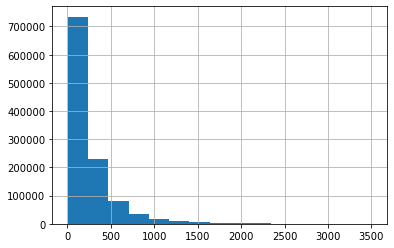

In [150]:
full_data['buy_all'].hist(bins=15)

<AxesSubplot:>

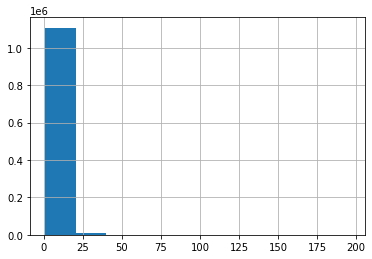

In [153]:
full_data['c_by_all'].hist(bins=10)

In [152]:
full_data['c_by_all'].max()

196

In [181]:
# Нормализация данных.

scaler = MaxAbsScaler()

NUMERIC_FEATURE = ['buy_in_this_m','buy_in_this_q','buy_in_this_y','buy_in_this_3y','buy_all',
                   'last_buy', 'c_buy_in_this_m', 'c_buy_in_this_q', 'c_buy_in_this_y', 'c_buy_in_this_3y',
                  'c_by_all', 'c_last_buy']

full_data_norm = full_data.copy()
full_data_norm[NUMERIC_FEATURE] = scaler.fit_transform(full_data_norm[NUMERIC_FEATURE])

In [182]:
full_data_norm.describe()

buy_in_this_m  buy_in_this_q  buy_in_this_y  buy_in_this_3y  \
count   1.117600e+06   1.117600e+06   1.117600e+06    1.117600e+06   
mean    8.074131e-02   9.042111e-02   8.169039e-02    7.144538e-02   
std     9.514039e-02   8.672217e-02   8.866142e-02    8.058891e-02   
min     0.000000e+00   9.469697e-04   3.372681e-04    8.551881e-04   
25%     0.000000e+00   3.219697e-02   2.630691e-02    2.251995e-02   
50%     5.357143e-02   6.250000e-02   5.092749e-02    4.389966e-02   
75%     1.224490e-01   1.212121e-01   1.028668e-01    8.893957e-02   
max     1.000000e+00   1.000000e+00   1.000000e+00    1.000000e+00   

            buy_all      last_buy  c_buy_in_this_m  c_buy_in_this_q  \
count  1.117600e+06  1.117600e+06     1.117600e+06     1.117600e+06   
mean   7.156634e-02  2.579692e-01     1.433753e-02     1.573080e-02   
std    8.097160e-02  2.727298e-01     2.755161e-02     2.160371e-02   
min    8.551881e-04  0.000000e+00     0.000000e+00     0.000000e+00   
25%    2.251995e-02  4.494382e-02     0.000000e+00     0.000000e+00   
50%    4.389966e-02  1.460674e-01     0.000000e+00     1.282051e-02   
75%    8.893957e-02  4.044944e-01     3.448276e-02     2.564103e-02   
max    1.000000e+00  1.000000e+00     1.000000e+00     1.000000e+00   

       c_buy_in_this_y  c_buy_in_this_3y  ...  share_category_in_this_y  \
count     1.117600e+06      1.117600e+06  ...              1.117600e+06   
mean      1.389999e-02      1.424213e-02  ...              1.789549e-02   
std       1.898350e-02      1.988944e-02  ...              2.004907e-02   
min       0.000000e+00      0.000000e+00  ...              0.000000e+00   
25%       5.102041e-03      5.102041e-03  ...              6.230530e-03   
50%       5.102041e-03      5.102041e-03  ...              1.265823e-02   
75%       1.530612e-02      1.530612e-02  ...              2.352941e-02   
max       1.000000e+00      1.000000e+00  ...              1.000000e+00   

       share_category_in_this_q  share_category_in_this_m  \
count              1.117600e+06              1.117600e+06   
mean               1.789549e-02              1.190497e-02   
std                2.841791e-02              2.942994e-02   
min                0.000000e+00              0.000000e+00   
25%                0.000000e+00              0.000000e+00   
50%                1.052632e-02              0.000000e+00   
75%                2.564103e-02              1.470588e-02   
max                1.000000e+00              1.000000e+00   

       interest_category_in_m  interest_category_in_q  interest_category_in_y  \
count            1.117600e+06            1.117600e+06            1.117600e+06   
mean             1.743650e-01            5.092602e-01            9.839089e-01   
std              3.278185e-01            4.408704e-01            1.092270e-01   
min              0.000000e+00            0.000000e+00            0.000000e+00   
25%              0.000000e+00            0.000000e+00            1.000000e+00   
50%              0.000000e+00            5.000000e-01            1.000000e+00   
75%              2.000000e-01            1.000000e+00            1.000000e+00   
max              1.000000e+00            1.000000e+00            1.000000e+00   

       interest_buy_y  interest_buy_q  interest_buy_m        target  
count    1.117600e+06    1.117600e+06    1.117600e+06  1.117600e+06  
mean     9.839760e-01    5.097836e-01    1.753343e-01  3.542010e-01  
std      7.834173e-02    3.139603e-01    2.106081e-01  4.782707e-01  
min      1.482480e-02    1.550388e-03    0.000000e+00  0.000000e+00  
25%      1.000000e+00    2.445652e-01    0.000000e+00  0.000000e+00  
50%      1.000000e+00    4.391534e-01    1.128205e-01  0.000000e+00  
75%      1.000000e+00    7.804878e-01    2.500000e-01  1.000000e+00  
max      1.000000e+00    1.000000e+00    1.000000e+00  1.000000e+00  

[8 rows x 23 columns]

In [75]:
from sklearn.model_selection import train_test_split

In [184]:
# Разбиение на тренировочную и тестовую выборку.

feautre = full_data_norm.columns[1:-1]
x_train, x_test, y_train, y_test = train_test_split(full_data_norm[feautre], full_data_norm['target'], test_size=0.3, random_state=0)

In [185]:
x_train

buy_in_this_m  buy_in_this_q  buy_in_this_y  buy_in_this_3y  \
1067373       0.020408       0.035038       0.012479        0.010547   
463199        0.071429       0.026515       0.034064        0.028791   
606665        0.107143       0.039773       0.023946        0.020239   
121802        0.283163       0.359848       0.323777        0.273660   
705088        0.058673       0.143939       0.087690        0.074116   
...                ...            ...            ...             ...   
359783        0.114796       0.070076       0.133221        0.112600   
152315        0.035714       0.061553       0.076560        0.064709   
963395        0.224490       0.169508       0.060371        0.051026   
117952        0.145408       0.177083       0.156492        0.132269   
305711        0.030612       0.022727       0.018212        0.015393   

          buy_all  last_buy  c_buy_in_this_m  c_buy_in_this_q  \
1067373  0.010547  0.078652         0.000000         0.012821   
463199   0.028791  0.101124         0.034483         0.012821   
606665   0.020239  0.011236         0.034483         0.012821   
121802   0.273660  0.000000         0.137931         0.128205   
705088   0.074116  0.269663         0.000000         0.000000   
...           ...       ...              ...              ...   
359783   0.112600  0.044944         0.000000         0.000000   
152315   0.064709  0.179775         0.000000         0.000000   
963395   0.051026  0.044944         0.034483         0.012821   
117952   0.132269  0.044944         0.000000         0.000000   
305711   0.015393  0.022472         0.034483         0.012821   

         c_buy_in_this_y  c_buy_in_this_3y  ...  share_category  \
1067373         0.005102          0.005102  ...        0.027027   
463199          0.005102          0.005102  ...        0.009901   
606665          0.005102          0.005102  ...        0.014085   
121802          0.071429          0.071429  ...        0.014583   
705088          0.005102          0.005102  ...        0.003846   
...                  ...               ...  ...             ...   
359783          0.005102          0.005102  ...        0.002532   
152315          0.010204          0.010204  ...        0.008811   
963395          0.005102          0.005102  ...        0.005587   
117952          0.005102          0.005102  ...        0.002155   
305711          0.010204          0.010204  ...        0.037037   

         share_category_in_this_y  share_category_in_this_q  \
1067373                  0.027027                  0.027027   
463199                   0.009901                  0.035714   
606665                   0.014085                  0.023810   
121802                   0.014583                  0.026316   
705088                   0.003846                  0.000000   
...                           ...                       ...   
359783                   0.002532                  0.000000   
152315                   0.008811                  0.000000   
963395                   0.005587                  0.005587   
117952                   0.002155                  0.000000   
305711                   0.037037                  0.041667   

         share_category_in_this_m  interest_category_in_m  \
1067373                  0.000000                0.000000   
463199                   0.035714                1.000000   
606665                   0.023810                1.000000   
121802                   0.036036                0.285714   
705088                   0.000000                0.000000   
...                           ...                     ...   
359783                   0.000000                0.000000   
152315                   0.000000                0.000000   
963395                   0.011364                1.000000   
117952                   0.000000                0.000000   
305711                   0.083333                0.500000   

         interest_category_in_q  interest_category_in_y  interest_bu

In [79]:
# Проверка базовых моделей.

!pip install lightgbm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

In [209]:
LR_MODEL = LogisticRegression(max_iter=50000, random_state=0, tol=1e-6)
RF_MODEL = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=150, min_samples_leaf=3)
XGB_MODEL = XGBClassifier(random_state=0)
LGBM_MODEL = LGBMClassifier(random_state=0)
KNN_MODEL = KNeighborsClassifier(n_neighbors=10, weights="uniform", leaf_size=100)

In [201]:
LR_MODEL.fit(x_train, y_train)

prdict_train = LR_MODEL.predict(x_train)
predict_test = LR_MODEL.predict(x_test)

LR_f1_train = f1_score(y_train, prdict_train)
LR_f1_test = f1_score(y_test, predict_test)

print(f'F1 score for train: {LR_f1_train}')
print(f'F1 score for test: {LR_f1_test}')

F1 score for train: 0.1510124853806541
F1 score for test: 0.148493209588992


In [210]:
RF_MODEL.fit(x_train, y_train)

RF_prdict_train = RF_MODEL.predict(x_train)
RF_predict_test = RF_MODEL.predict(x_test)

RF_f1_train = f1_score(y_train, RF_prdict_train)
RF_f1_test = f1_score(y_test, RF_predict_test)

print(f'F1 score for train: {RF_f1_train}')
print(f'F1 score for test: {RF_f1_test}')

F1 score for train: 0.7644703608652191
F1 score for test: 0.47858429529669283


In [211]:
XGB_MODEL.fit(x_train, y_train)

XGB_prdict_train = XGB_MODEL.predict(x_train)
XGB_predict_test = XGB_MODEL.predict(x_test)

XGB_f1_train = f1_score(y_train, XGB_prdict_train)
XGB_f1_test = f1_score(y_test, XGB_predict_test)

print(f'F1 score for train: {XGB_f1_train}')
print(f'F1 score for test: {XGB_f1_test}')

C:\Users\Ergney\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:11:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score for train: 0.2607417786157808
F1 score for test: 0.24087076852112857


In [212]:
LGBM_MODEL.fit(x_train, y_train)

LGBM_prdict_train = LGBM_MODEL.predict(x_train)
LGBM_predict_test = LGBM_MODEL.predict(x_test)

LGBM_f1_train = f1_score(y_train, LGBM_prdict_train)
LGBM_f1_test = f1_score(y_test, LGBM_predict_test)

print(f'F1 score for train: {LGBM_f1_train}')
print(f'F1 score for test: {LGBM_f1_test}')

F1 score for train: 0.06892437931999017
F1 score for test: 0.06414173713257064


In [214]:
# Как виднно лучше всего справляется модель случайного леса. 
#По идее надо бы ещё подобрать гиперпараметры, но у меня нет столько времени.

x_train, x_test, y_train, y_test = train_test_split(full_data[feautre], full_data['target'], test_size=0.3, random_state=0)

In [215]:
RF_MODEL_2 = RandomForestClassifier(n_estimators=150)

RF_MODEL_2.fit(x_train, y_train)

RF2_prdict_train = RF_MODEL_2.predict(x_train)
RF2_predict_test = RF_MODEL_2.predict(x_test)

RF2_f1_train = f1_score(y_train, RF2_prdict_train)
RF2_f1_test = f1_score(y_test, RF2_predict_test)

print(f'F1 score for train: {RF2_f1_train}')
print(f'F1 score for test: {RF2_f1_test}')

F1 score for train: 0.8167186855044863
F1 score for test: 0.49275325042760326


In [216]:
FINAL_PREDICT = RF_MODEL_2.predict(full_data[feautre])

In [217]:
FINAL_PREDICT

array([1., 1., 1., ..., 0., 1., 0.])

## UPD. Предсказал несовсем то что нужно было. Это второй ноутбут, он почти не отлчичается от первого, просто готовые обработтаные данный загружены из фаила и заного обучена модель и получены предсказания. Раличия ноутбуков только в самом конце.

In [35]:
#FINAL_PREDICT = pd.DataFrame(data = FINAL_PREDICT['target'].values, index = full_data['id'].values, columns=['target'])

In [37]:
#FINAL_PREDICT = pd.read_csv("FINAL_PREDICT.csv")

target
0;5           1.0
0;10          1.0
0;14          1.0
0;20          0.0
0;22          1.0
...           ...
19998;409     1.0
19998;415     0.0
19998;420     0.0
19998;798     1.0
19999;326     0.0

[1117600 rows x 1 columns]

In [71]:
new_data = pd.read_csv('newdata.csv', encoding="utf-8")
target = pd.read_csv("C://Users//Ergney//Downloads//data//sample_submission.csv")

#FINAL_PREDICT.to_csv('FINAL_PREDICT.csv', encoding="utf-8", index=False)

In [72]:
full_data = pd.merge(new_data, target, on='id', how='inner')

In [73]:
full_data

Unnamed: 0         id  buy_in_this_m  buy_in_this_q  buy_in_this_y  \
0                0        0;5             36             44             44   
1                1       0;10             36             44             44   
2                2       0;14             36             44             44   
3                3       0;20             36             44             44   
4                4       0;22             36             44             44   
...            ...        ...            ...            ...            ...   
790444     1117594  19998;398             19             19             19   
790445     1117595  19998;409             19             19             19   
790446     1117596  19998;415             19             19             19   
790447     1117597  19998;420             19             19             19   
790448     1117598  19998;798             19             19             19   

        buy_in_this_3y  buy_all  last_buy  c_buy_in_this_m  c_buy_in_this_q  \
0                   44       44         1                1                1   
1                   44       44         1                1                1   
2                   44       44         1                1                2   
3                   44       44         1                0                1   
4                   44       44         1                1                1   
...                ...      ...       ...              ...              ...   
790444              19       19         1                2                2   
790445              19       19         1                1                1   
790446              19       19         1                2                2   
790447              19       19         1                2                2   
790448              19       19         1                1                1   

        ...  share_category_in_this_y  share_category_in_this_q  \
0       ...                  0.022727                  0.022727   
1       ...                  0.022727                  0.022727   
2       ...                  0.045455                  0.045455   
3       ...                  0.022727                  0.022727   
4       ...                  0.022727                  0.022727   
...     ...                       ...                       ...   
790444  ...                  0.105263                  0.105263   
790445  ...                  0.052632                  0.052632   
790446  ...                  0.105263                  0.105263   
790447  ...                  0.105263                  0.105263   
790448  ...                  0.052632                  0.052632   

        share_category_in_this_m  interest_category_in_m  \
0                       0.027778                     1.0   
1                       0.027778                     1.0   
2                       0.027778                     0.5   
3                       0.000000                     0.0   
4                       0.027778                     1.0   
...                          ...                     ...   
790444                  0.105263                     1.0   
790445                  0.052632                     1.0   
790446                  0.105263                     1.0   
790447                  0.105263                     1.0   
790448                  0.052632                     1.0   

        interest_category_in_q  interest_category_in_y  interest_buy_y  \
0                          1.0                     1.0             1.0   
1                          1.0                     1.0             1.0   
2                          1.0                     1.0             1.0   
3                          1.0                     1.0             1.0   
4                          1.0                     1.0             1.0   
...                        ...                     ...             ...   
790444                     1.0                     1.0             1.0   
7904

In [83]:
feautre = full_data.columns[2:-1]

x_train, x_test, y_train, y_test = train_test_split(full_data[feautre], full_data['target'], test_size=0.3, random_state=0)

In [84]:
RF_MODEL_3 = RandomForestClassifier(n_estimators=150)

RF_MODEL_3.fit(x_train, y_train)

RF3_prdict_train = RF_MODEL_3.predict(x_train)
RF3_predict_test = RF_MODEL_3.predict(x_test)

RF3_f1_train = f1_score(y_train, RF3_prdict_train)
RF3_f1_test = f1_score(y_test, RF3_predict_test)

print(f'F1 score for train: {RF3_f1_train}')
print(f'F1 score for test: {RF3_f1_test}')

F1 score for train: 0.8177963193729569
F1 score for test: 0.5026593620053902


In [85]:
FINAL_PREDICT = RF_MODEL_3.predict(full_data[feautre])

In [88]:
FINAL_PREDICT = pd.DataFrame({'id':full_data["id"].values, "target":FINAL_PREDICT})

In [90]:
FINAL_PREDICT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


In [52]:
#FINAL_PREDICT["target"] = FINAL_PREDICT["target"].astype("int64")

In [91]:
FINAL_PREDICT.to_csv("FINAL_PREDICT.csv", index=False)

In [229]:
import pickle

In [230]:
MODEL_FILE_PATH = './model.pkl'

with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(RF_MODEL_2, file)